# Image classification with Neural Networks

## Machine Learning Project


\
**Group:** Andrea Ierardi, Emanuele Morales, Gregorio Luigi Saporito


## 1. Data Loading

In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import random
import pandas as pd 


from sklearn.datasets import load_files
import numpy as np
DATADIR = "dataset/fruits-360/Training"
DATADIR_test = "dataset/fruits-360/Test"

CATEGORIES = ["Apple Braeburn","Apple Crimson Snow","Apple Golden 1","Apple Golden 2","Apple Golden 3",
              "Apple Granny Smith","Apple Pink Lady","Apple Red 1", "Apple Red 2","Apple Red 3","Apple Red Delicious",
              "Apple Red Yellow 1","Apple Red Yellow 2","Banana",
              "Plum","Plum 2", "Plum 3",
             "Pepper Yellow","Pepper Red","Pepper Green",
              "Cherry 1", "Cherry 2", "Cherry Rainier", "Cherry Wax Black", "Cherry Wax Red","Cherry Wax Yellow",
              "Grape Blue", "Grape Pink", "Grape White", "Grape White 2", "Grape White 3", "Grape White 4",
            "Tomato 1","Tomato 2","Tomato 3","Tomato 4","Tomato Yellow","Tomato Maroon",
            "Pear","Pear Abate","Pear Forelle","Pear Kaiser","Pear Monster","Pear Red","Pear Williams",
             "Peach","Peach 2","Peach Flat",
             "Potato Red", "Potato Red Washed","Potato White","Potato Sweet"
             ]

##TYPES = ["Apple", "Banana", "Plum", "Pepper", "Cherry", "Grape", "Tomato", "Potato", "Pear", "Peach"]
TYPES = ["Apple", "Banana", "Plum", "Pepper", "Cherry", "Grape", "Tomato", "Potato", "Pear", "Peach"]
fruits= {}
for cat in CATEGORIES:
    for typ in TYPES:
        if(cat.startswith(typ)):
            fruits[cat] = typ
            
            
def load_dataset(dire):
    lis_files = []
    lis_num_lab =[]
    lis_name_lab = []
    for category in CATEGORIES:
        path = os.path.join(dire,category)
        class_num =TYPES.index(fruits[category])

        class_name = fruits[category]
        for img in tqdm(os.listdir(path)):
               # print("OK: ",os.path.join(path,img) )
                lis_files.append(os.path.join(path,img))
                lis_name_lab.append(class_name)
                lis_num_lab.append(class_num)
                #print("path:  ",os.path.join(path,img)," \n Name: ",class_name," \n Id: ",class_num)

    return pd.DataFrame(list(zip(lis_files,lis_num_lab,lis_name_lab)),columns=('path','label_id',"label_name"))

all_train = load_dataset(DATADIR)
all_test = load_dataset(DATADIR_test)


all_train = all_train.sample(frac=1, axis=1).sample(frac=1).reset_index(drop=True)
all_test = all_test.sample(frac=1, axis=1).sample(frac=1).reset_index(drop=True)

x_train = np.array(all_train["path"])
y_train = np.array(all_train["label_id"])
target_labels= np.array(all_train["label_name"])

x_test = np.array(all_test["path"])
y_test = np.array(all_test["label_id"])


100%|█████████████████████████████████████| 151/151 [00:00<00:00, 75505.47it/s]


100%|████████████████████████████████████| 150/150 [00:00<00:00, 150082.44it/s]


## 1.2 Pre-processing

In [23]:


from keras.utils import np_utils
no_of_classes = len(np.unique(y_train))
y_train = np_utils.to_categorical(y_train,no_of_classes)
y_test = np_utils.to_categorical(y_test,no_of_classes)
y_train[0]
print("Number of classes: ",no_of_classes)



# Now, we have to divide the validation set into test and validation set
x_test,x_valid = x_test[7000:],x_test[:7000]
y_test,y_vaild = y_test[7000:],y_test[:7000]
print('Vaildation X : ',x_valid.shape)
print('Vaildation y :',y_vaild.shape)
print('Test X : ',x_test.shape)
print('Test y : ',y_test.shape)



from keras.preprocessing.image import array_to_img, img_to_array, load_img

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file,target_size=(32, 32))))
    return images_as_array

x_train = np.array(convert_image_to_array(x_train))
print('Training set shape : ',x_train.shape)
print(type(x_train))
x_valid = np.array(convert_image_to_array(x_valid))
print('Validation set shape : ',x_valid.shape)

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

print('1st training image shape ',x_train[0].shape)


x_train = x_train.astype('float32')/255
x_valid = x_valid.astype('float32')/255
x_test = x_test.astype('float32')/255



Number of classes:  10
Vaildation X :  (7000,)
Vaildation y : (7000, 10)
Test X :  (2335,)
Test y :  (2335, 10)
Training set shape :  (27908, 32, 32, 3)
<class 'numpy.ndarray'>
Validation set shape :  (7000, 32, 32, 3)
Test set shape :  (2335, 32, 32, 3)
1st training image shape  (32, 32, 3)


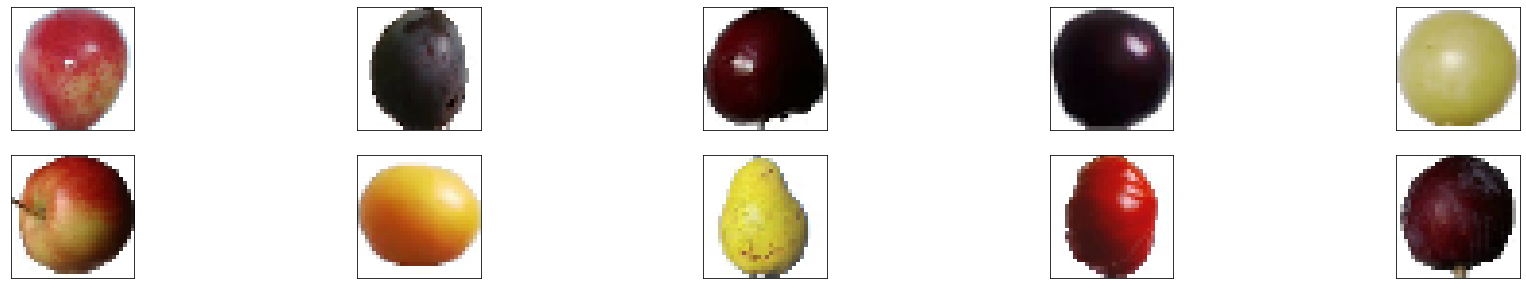

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize =(30,5))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_train[i]))



## 1.3 Convolutional Neural Newtworks

### First Approach 

In [4]:
#Simple CNN from scratch - we are using 3 Conv layers followed by maxpooling layers.
# At the end we add dropout, flatten and some fully connected layers(Dense).

from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import backend as K

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 2,input_shape=(32,32,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 32,kernel_size = 2,activation= 'relu',padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 64,kernel_size = 2,activation= 'relu',padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 128,kernel_size = 2,activation= 'relu',padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(150))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(10,activation = 'softmax'))
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        208       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 64)         

In [5]:

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print('Compiled!')




Compiled!


In [6]:

history = model.fit(x_train,y_train,
        batch_size = 32,
        epochs=10,
        validation_data=(x_valid, y_vaild),
        verbose=2, 
     #   shuffle=True
                   )



Train on 27908 samples, validate on 7000 samples
Epoch 1/10
 - 14s - loss: 0.7901 - accuracy: 0.7232 - val_loss: 0.1869 - val_accuracy: 0.9301
Epoch 2/10
 - 14s - loss: 0.1090 - accuracy: 0.9626 - val_loss: 0.0623 - val_accuracy: 0.9773
Epoch 3/10
 - 13s - loss: 0.0482 - accuracy: 0.9839 - val_loss: 0.0912 - val_accuracy: 0.9683
Epoch 4/10
 - 14s - loss: 0.0350 - accuracy: 0.9886 - val_loss: 0.0295 - val_accuracy: 0.9901
Epoch 5/10
 - 14s - loss: 0.0233 - accuracy: 0.9921 - val_loss: 0.0340 - val_accuracy: 0.9906
Epoch 6/10
 - 15s - loss: 0.0218 - accuracy: 0.9934 - val_loss: 0.0583 - val_accuracy: 0.9859
Epoch 7/10
 - 16s - loss: 0.0177 - accuracy: 0.9946 - val_loss: 0.1128 - val_accuracy: 0.9706
Epoch 8/10
 - 14s - loss: 0.0189 - accuracy: 0.9949 - val_loss: 0.0467 - val_accuracy: 0.9884
Epoch 9/10
 - 15s - loss: 0.0150 - accuracy: 0.9958 - val_loss: 0.0298 - val_accuracy: 0.9933
Epoch 10/10
 - 15s - loss: 0.0162 - accuracy: 0.9951 - val_loss: 0.0143 - val_accuracy: 0.9947


In [7]:

# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])



 Test accuracy: 0.9922912120819092


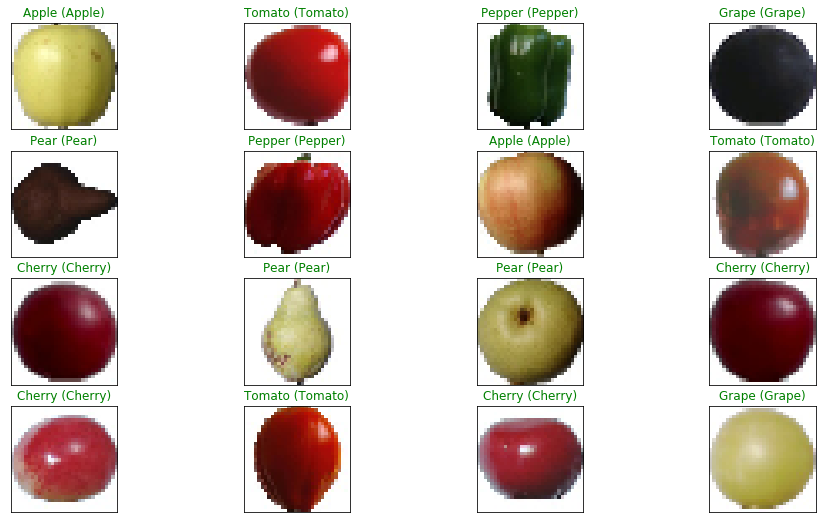

In [8]:
y_pred = model.predict(x_test)

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(TYPES[pred_idx], TYPES[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))
    


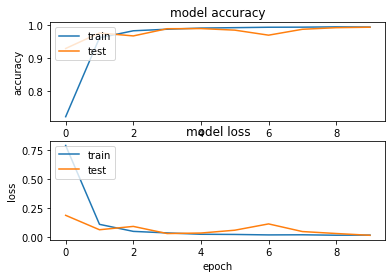

In [9]:
#Finally lets visualize the loss and accuracy wrt epochs

import matplotlib.pyplot as plt 
plt.figure(1)  
   
 # summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

### Parameters Tuning

In [ ]:
from datetime import datetime
from keras.callbacks import TensorBoard

from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import backend as K
dense_layers = [0, 1, 2]
layer_sizes = [32, 64, 128]
conv_layers = [1, 2, 3]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "Fruits-{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, datetime.now().strftime("%d%m%Y-%H%M%S"))
            print(NAME)

            model = Sequential()

            model.add(Conv2D(layer_size, 2, input_shape=(32,32,3),padding='same'))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=2))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, 2))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=2))

            model.add(Flatten())

            for _ in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation('relu'))

            model.add(Dense(10,activation = 'softmax'))
    

            tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
            #
            #!
            #categorical_crossentropy
            #!
            #
            model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
            print('Compiled!')
            
            history = model.fit(x_train,y_train,
        batch_size = 32,
        epochs=10,
        validation_data=(x_valid, y_vaild),
        verbose=2, 
        callbacks=[tensorboard]
        )

# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])

## 1.4 MobileNetV2

## 1.5 LeNet Neural Networks